In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T070715Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9e9cd1550cad364b0c729ddef30f9428b32c24bea14c386e04f5e2d891d3b3cc2a2ca2fa12337fdd3edcf39c74be4096c7b9c1297eae63c6d733d1bb3a970fb04ab0a455d8a09d41571b349c6daab512299854f5e951b275a5be7cc86976705514f384918a22536d7b0ea65440e73c809020009a41c928450c4c93cb63290972671672a5bf46662eabda1491964a0d10495f4a0a7866b9f49b867fc737ab09f021ca52a489ddbe24502a93e417493567e6c828d2fba2a9600c49988ba8d1e61a3af96d7133f32cd4d1163369390473fcf082dc105596d1d4413aa3981ab2c9ff3ae69d88f1d61a88c247595de2436bfe51fffbd08d83cd5637f77fe091f342aa'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 2463365435 bytes downloaded
Downloaded and uncompressed: chest-xray-pneumonia
Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person12_bacteria_47.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1249_virus_2118.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1864_bacteria_4736.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1005_bacteria_2936.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1926_bacteria_4835.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person58_bacteria_275.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1348_virus_2324.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1261_virus_2145.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person778_bacteria_2682.jpeg
/kaggle/input/chest-xray-pneumonia/ches

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
import keras
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dense, Flatten, ReLU, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

In [5]:
tf.__version__

'2.15.0'

In [6]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [7]:
normal_img = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
pneumonia_img = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1004_bacteria_2935.jpeg'

In [8]:
def show(img_path):
    img = plt.imread(img_path)
    print(img.shape)
    plt.imshow(img, cmap = 'gray')
    plt.show()
    return img

(1858, 2090)


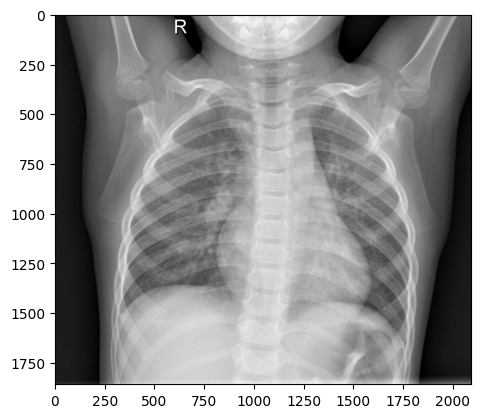

(1858, 2090)

In [9]:
test_img = show(normal_img)
test_img.shape

(816, 1184)


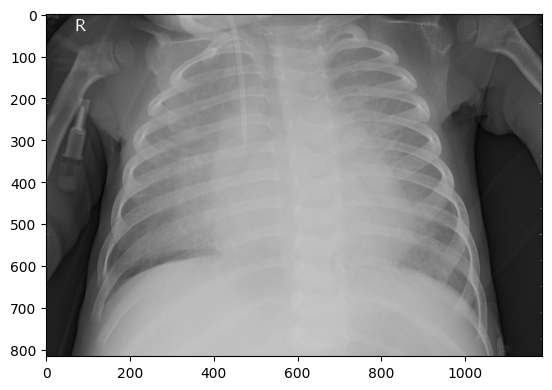

array([[61, 61, 60, ..., 28, 29, 29],
       [58, 59, 60, ..., 30, 33, 35],
       [58, 59, 60, ..., 35, 38, 39],
       ...,
       [30, 30, 30, ..., 30, 30, 30],
       [30, 30, 30, ..., 30, 30, 30],
       [30, 30, 30, ..., 30, 30, 30]], dtype=uint8)

In [10]:
show(pneumonia_img)

In [11]:
TARGET_IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [12]:
train_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/train'
test_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/test'
val_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/val'

In [13]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                          featurewise_center = False,
                                          samplewise_center = False,
                                          rotation_range = 90,
                                          zoom_range = 0.1,
                                          width_shift_range = 0.1,
                                          height_shift_range = 0.1,
                                          horizontal_flip = True,
                                          vertical_flip = True,
                                          validation_split = 0.2)

test_data_generator = ImageDataGenerator(rescale = 1./255)

# val_data_generator = ImageDataGenerator(rescale = 1./255)

In [14]:
train_data_iterator = train_data_generator.flow_from_directory(train_dir,
                                                               target_size = TARGET_IMG_SIZE,
                                                               batch_size = BATCH_SIZE,
                                                               class_mode = 'binary',
                                                               subset = 'training')

test_data_iterator = test_data_generator.flow_from_directory(test_dir,
                                                               target_size = TARGET_IMG_SIZE,
                                                               batch_size = BATCH_SIZE,
                                                               class_mode = 'binary')

val_data_iterator = train_data_generator.flow_from_directory(train_dir,
                                                               target_size = TARGET_IMG_SIZE,
                                                               batch_size = BATCH_SIZE,
                                                               class_mode = 'binary',
                                                               subset = 'validation')

Found 4173 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [15]:
print(train_data_iterator)

In [16]:
xtrain, ytrain = next(train_data_iterator)

In [17]:
xtrain, ytrain

(array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [1.56960815e-01, 1.56960815e-01, 1.56960815e-01],
          [1.54811978e-01, 1.54811978e-01, 1.54811978e-01],
          [1.52524114e-01, 1.52524114e-01, 1.52524114e-01]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [1.47582620e-01, 1.47582620e-01, 1.47582620e-01],
          [1.44359380e-01, 1.44359380e-01, 1.44359380e-01],
          [1.41216844e-01, 1.41216844e-01, 1.41216844e-01]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [1.46158308e-01, 1.46158308e-01, 1.4615

In [18]:
test_img.shape[0], test_img.shape[1]

(1858, 2090)

In [19]:
tf.random.set_seed(34)

model = Sequential([
    keras.Input(shape = (224, 224, 3)),
    Conv2D(filters = 32, kernel_size = (3, 3), strides = 1, padding = 'same', input_shape = (224, 224, 3)),
    BatchNormalization(axis = 1),
    LeakyReLU(),

    Conv2D(filters = 32, kernel_size = (3, 3), strides = 1, padding = 'same'),
    BatchNormalization(axis = 1),
    LeakyReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = 2),

    Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, padding = 'same'),
    BatchNormalization(axis = 1),
    LeakyReLU(),

    Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, padding = 'same'),
    BatchNormalization(axis = 1),
    LeakyReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = 2),

    Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, padding = 'same'),
    BatchNormalization(axis = 1),
    LeakyReLU(),

    Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, padding = 'same'),
    BatchNormalization(axis = 1),
    LeakyReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = 2),

    Conv2D(filters = 256, kernel_size = (3, 3), strides = 1, padding = 'same'),
    BatchNormalization(axis = 1),
    LeakyReLU(),

    Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, padding = 'same'),
    BatchNormalization(axis = 1),
    LeakyReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = 2),

    Conv2D(filters = 1024, kernel_size = (3, 3), strides = 1, padding = 'same'),
    BatchNormalization(axis = 1),
    LeakyReLU(),

    Conv2D(filters = 512, kernel_size = (3, 3), strides = 1, padding = 'same'),
    Dropout(0.5),
    BatchNormalization(axis = 1),
    LeakyReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = 2),

    Flatten(),
    Dense(units = 512, activation = 'relu'),
    Dense(units = 1024, activation = 'relu'),
    Dense(units = 512, activation = 'relu'),
    Dense(units = 512, activation = 'relu'),
    Dense(units = 256, activation = 'relu'),
    Dense(units = 64, activation = 'relu'),
    Dense(units = 1, activation = 'sigmoid')
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      896       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 32)      896       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 224, 224, 32)      0

In [21]:
from keras.utils import plot_model

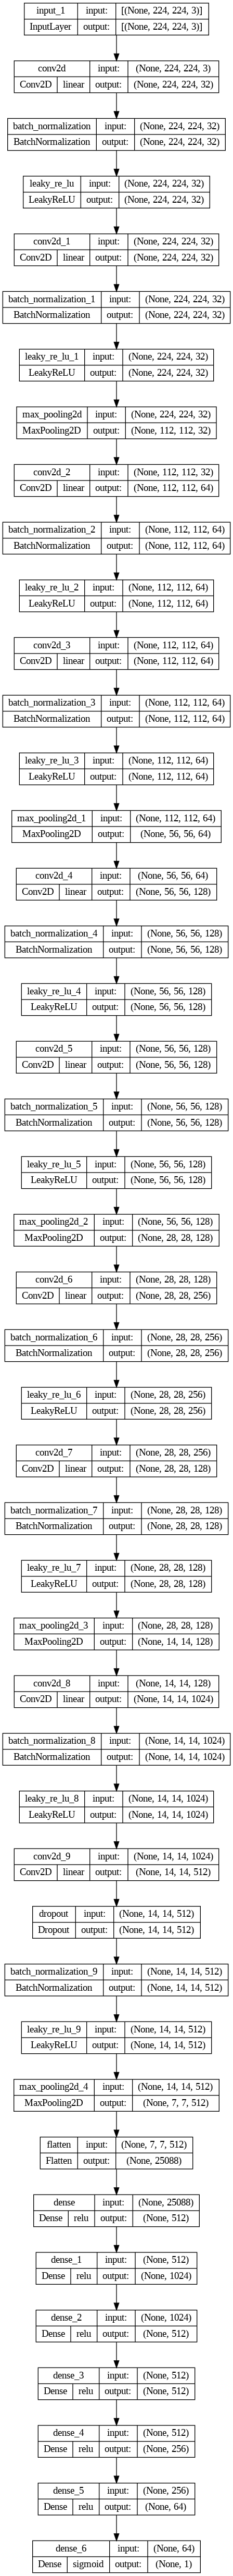

In [22]:
plot_model(model, show_shapes = True, show_layer_activations = True)

In [23]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 3, monitor = 'val_loss', restore_best_weights = True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = 'cnn_anomalymodel_weights.hdf5', monitor = 'val_loss', save_best_only = True)

In [25]:
history = model.fit(train_data_iterator, epochs = 5, batch_size = 32, validation_data = val_data_iterator, verbose = 1, callbacks = [model_checkpoint])

Epoch 1/5
131/131 [==============================] - ETA: 0s - loss: 0.7540 - accuracy: 0.7045

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 140s 902ms/step - loss: 0.7540 - accuracy: 0.7045 - val_loss: 0.5545 - val_accuracy: 0.7430
Epoch 2/5
131/131 [==============================] - 112s 855ms/step - loss: 0.5779 - accuracy: 0.7429 - val_loss: 0.5622 - val_accuracy: 0.7430
Epoch 3/5
131/131 [==============================] - 117s 892ms/step - loss: 0.5393 - accuracy: 0.7426 - val_loss: 0.5353 - val_accuracy: 0.7430
Epoch 4/5
131/131 [==============================] - 112s 857ms/step - loss: 0.4297 - accuracy: 0.8042 - val_loss: 0.6164 - val_accuracy: 0.7469
Epoch 5/5
131/131 [==============================] - 112s 854ms/step - loss: 0.4058 - accuracy: 0.8157 - val_loss: 0.5691 - val_accuracy: 0.7430


In [26]:
def plot_accuracy_loss (history):
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], 'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("Training vs Validation Accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot Loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], 'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("Training vs Validation Loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

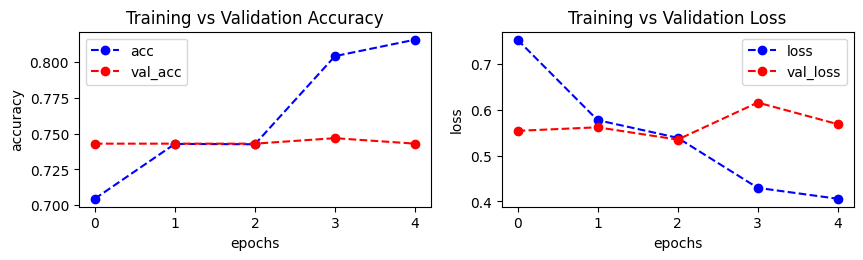

In [27]:
plot_accuracy_loss(history)

In [28]:
train_data_iterator = train_data_generator.flow_from_directory(train_dir,
                                                               target_size = TARGET_IMG_SIZE,
                                                               batch_size = BATCH_SIZE,
                                                               class_mode = 'binary',
                                                               subset = 'training')

test_data_iterator = test_data_generator.flow_from_directory(test_dir,
                                                               target_size = TARGET_IMG_SIZE,
                                                               batch_size = BATCH_SIZE,
                                                               class_mode = 'binary')

val_data_iterator = train_data_generator.flow_from_directory(train_dir,
                                                               target_size = TARGET_IMG_SIZE,
                                                               batch_size = BATCH_SIZE,
                                                               class_mode = 'binary',
                                                               subset = 'validation')

Found 4173 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [29]:
resnet = Sequential()

pretrained_model = tf.keras.applications.ResNet50(include_top = False,
                                                  input_shape = (224, 224, 3),
                                                  pooling = 'avg',
                                                  weights = 'imagenet')

for each_layer in pretrained_model.layers:
  each_layer.trainable = False

resnet.add(pretrained_model)
resnet.add(Flatten())
resnet.add(Dense(512, activation = 'relu'))
resnet.add(Dense(1, activation = 'sigmoid'))

94765736/94765736 [==============================] - 1s 0us/step


In [30]:
resnet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [31]:
resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               1049088   
                                                                 
 dense_8 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24637313 (93.98 MB)
Trainable params: 1049601 (4.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [32]:
from keras.utils import plot_model

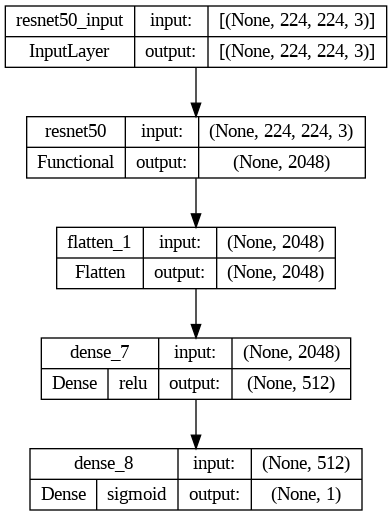

In [33]:
plot_model(resnet, show_shapes = True, show_layer_activations = True)

In [34]:
history_resnet = resnet.fit(train_data_iterator, epochs = 5, validation_data = val_data_iterator)

Epoch 1/5
131/131 [==============================] - 111s 805ms/step - loss: 0.5595 - accuracy: 0.7371 - val_loss: 0.4927 - val_accuracy: 0.7948
Epoch 2/5
131/131 [==============================] - 102s 781ms/step - loss: 0.4583 - accuracy: 0.7853 - val_loss: 0.4552 - val_accuracy: 0.8025
Epoch 3/5
131/131 [==============================] - 103s 785ms/step - loss: 0.4252 - accuracy: 0.7994 - val_loss: 0.3999 - val_accuracy: 0.7843
Epoch 4/5
131/131 [==============================] - 103s 783ms/step - loss: 0.3930 - accuracy: 0.8121 - val_loss: 0.4020 - val_accuracy: 0.8207
Epoch 5/5
131/131 [==============================] - 102s 780ms/step - loss: 0.3775 - accuracy: 0.8174 - val_loss: 0.3702 - val_accuracy: 0.8082


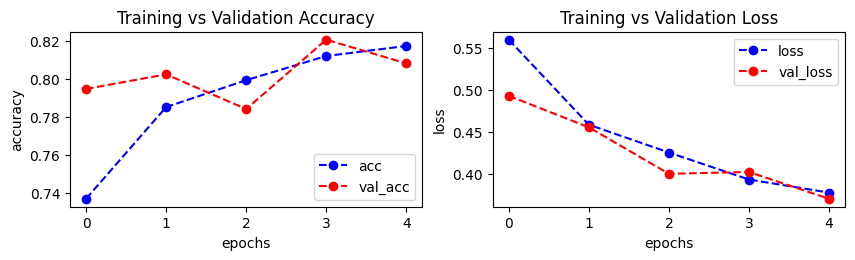

In [35]:
plot_accuracy_loss(history_resnet)

In [36]:
loss_res, acc_res = resnet.evaluate(test_data_iterator)

20/20 [==============================] - 7s 330ms/step - loss: 0.4938 - accuracy: 0.7612


In [37]:
loss, acc = model.evaluate(test_data_iterator)

20/20 [==============================] - 7s 366ms/step - loss: 0.5327 - accuracy: 0.7340


In [ ]:
xtest, ytest = next(test_data_iterator)

In [ ]:
probs = model.predict(xtest)

In [54]:
probs = model.predict(xtest)

1/1 [==============================] - 0s 44ms/step


In [57]:
preds = (probs > 0.5).astype(int)
preds

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1]])

In [58]:
probs_resnet = resnet.predict(xtest)

1/1 [==============================] - 1s 1s/step


In [59]:
preds_resnet = (probs_resnet > 0.5).astype(int)
preds_resnet

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1]])

In [60]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve

<Axes: >

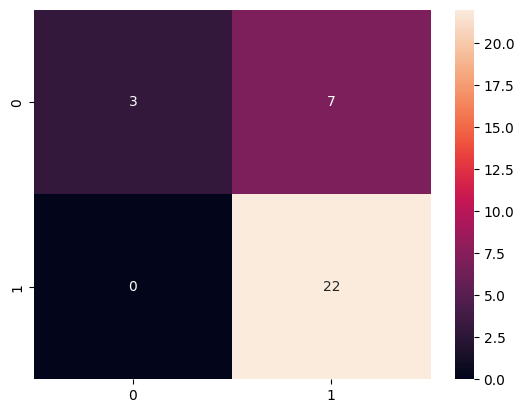

In [61]:
sns.heatmap(confusion_matrix(ytest, preds), annot = True)

<Axes: >

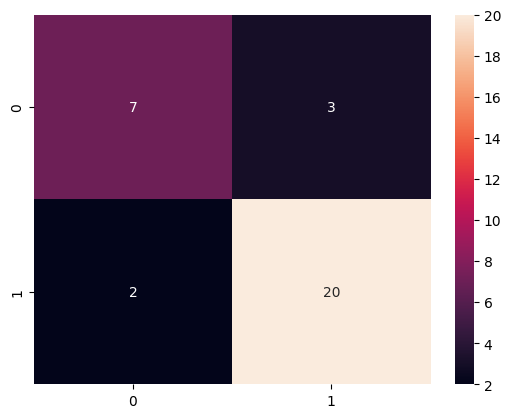

In [62]:
sns.heatmap(confusion_matrix(ytest, preds_resnet), annot = True)

In [63]:
print(classification_report(ytest, preds))

              precision    recall  f1-score   support

         0.0       1.00      0.30      0.46        10
         1.0       0.76      1.00      0.86        22

    accuracy                           0.78        32
   macro avg       0.88      0.65      0.66        32
weighted avg       0.83      0.78      0.74        32



In [64]:
print(classification_report(ytest, preds_resnet))

              precision    recall  f1-score   support

         0.0       0.78      0.70      0.74        10
         1.0       0.87      0.91      0.89        22

    accuracy                           0.84        32
   macro avg       0.82      0.80      0.81        32
weighted avg       0.84      0.84      0.84        32

